# Данные

In [1]:
import shutil

# Пытаемся взять copy_tree из distutils или setuptools._distutils
try:
    from distutils.dir_util import copy_tree
except ImportError:
    # Для Python 3.12+, где distutils выпилен, но есть в setuptools
    from setuptools._distutils.dir_util import copy_tree  # type: ignore

# Если в shutil нет copy_tree — добавляем
if not hasattr(shutil, "copy_tree"):
    shutil.copy_tree = copy_tree  # type: ignore


import moabb.datasets

m_dataset = moabb.datasets.BI2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)

m_dataset.download()

In [2]:
from moabb.paradigms import P300

paradigm = P300()  # или P300(fmin=1, fmax=20, ...) при желании

X, y, meta = paradigm.get_data(
    dataset=m_dataset,
    subjects=[1],   # список субъектов
)

print(X.shape)     # (n_trials, n_channels, n_times)
print(y.shape)     # (n_trials,)
print(meta.head())

/home/mamura/.conda/envs/ais/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/mamura/.conda/envs/ais/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/mamura/.conda/envs/ais/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/mamura/.conda/envs/ais/lib/python3.12/si

(8292, 16, 513)
(8292,)
   subject session run
0        1       2   0
1        1       2   0
2        1       2   0
3        1       2   0
4        1       2   0


In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [4]:
import torch
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline

le = LabelEncoder()
y_enc = le.fit_transform(y)
 
print("Classes:", le.classes_)
print("Encoded y:", np.unique(y_enc))


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, random_state=42, test_size=0.2, stratify=y_enc
)

y_train_svm = 2 * y_train - 1   # 0 -> -1, 1 -> +1
y_test_svm  = 2 * y_test - 1

flatten = FunctionTransformer(
    lambda X: X.reshape(X.shape[0], -1),  # (N, C, T) -> (N, C*T)
    validate=False
)

pipe = Pipeline([
    ("flatten", flatten),
    ("scaler", StandardScaler()),
])

X_train_scaled = pipe.fit_transform(X_train)
X_test_scaled = pipe.transform(X_test)      

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_np = X_train_scaled.astype(np.float32)
X_test_np  = X_test_scaled.astype(np.float32)

y_train_svm_np = y_train_svm.astype(np.float32)
y_test_svm_np  = y_test_svm.astype(np.float32)


Classes: ['NonTarget' 'Target']
Encoded y: [0 1]
X_train_scaled shape: (6633, 8208)
X_test_scaled shape: (1659, 8208)


# Модель

In [5]:
torch.cuda.is_available()

True

In [25]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

class SVM:
    def __init__(
        self, 
        lr: float = 1e-2,
        C: float = 0.1,
        epochs: int = 100,
        batch_size: int = 64,
        device: str = None,
    ):
        self.lr = lr
        self.C = C
        self.epochs = epochs
        self.batch_size = batch_size
        self._w = None
        self._b = None
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    def _prepare_data(self, X: np.ndarray, y: np.ndarray):
        X_np = X.astype(np.float32)
        y_np = y.astype(np.float32)  # expect y already in -1/+1; if 0/1 convert first

        X_t = torch.from_numpy(X_np)
        y_t = torch.from_numpy(y_np)

        dataset = TensorDataset(X_t, y_t)
        self._data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.matmul(self._w) + self._b

    def _loss_batch(self, X_batch: torch.Tensor, y_batch: torch.Tensor):
        scores = self.forward(X_batch)                     
        hinge = torch.clamp(1 - y_batch * scores, min=0.0) 
        loss_margin = hinge.mean()                         
        l2 = 0.5 * torch.sum(self._w ** 2)                 
        
        return l2 + self.C * loss_margin

    def fit(self, X: np.ndarray, y: np.ndarray, verbose: bool = True):
        """
        X: (N, D) numpy
        y: (N,) numpy with values in {-1, +1}
        """
        self._prepare_data(X, y)
        n_samples, n_features = X.shape
        self._w = torch.zeros(n_features, dtype=torch.float32, device=self.device)
        self._b = torch.zeros(1, dtype=torch.float32, device=self.device)

        history = {"loss": []}

        for epoch in tqdm(range(self.epochs), desc="Epochs", disable=not verbose):
            epoch_loss = 0.0
            for X_batch, y_batch in self._data_loader:
                X_batch = X_batch.to(self.device).float()
                y_batch = y_batch.to(self.device).float()

                B = X_batch.shape[0]

                scores = self.forward(X_batch)                     
                margin = 1 - y_batch * scores                      
                mask = (margin > 0).float()

                
                if mask.sum() > 0:
                    mask_exp = mask.view(-1, 1)                  
                    y_masked = (y_batch * mask).view(-1, 1)
                    sum_yx = torch.sum(y_masked * X_batch, dim=0)
                    grad_w_margin = - (self.C / B) * sum_yx         
                    grad_b_margin = - (self.C / B) * torch.sum(y_batch * mask)
                else:
                    grad_w_margin = torch.zeros_like(self._w)
                    grad_b_margin = torch.zeros_like(self._b)

                grad_w_reg = self._w.clone()
                grad_b_reg = torch.zeros_like(self._b)

                grad_w = grad_w_reg + grad_w_margin
                grad_b = grad_b_reg + grad_b_margin  

                self._w = self._w - self.lr * grad_w
                self._b = self._b - self.lr * grad_b
                batch_loss = self._loss_batch(X_batch, y_batch).item()
                epoch_loss += batch_loss * B

            epoch_loss = epoch_loss / n_samples
            history["loss"].append(epoch_loss)

            if verbose and (epoch % max(1, self.epochs // 10) == 0):
                print(f"Epoch {epoch+1}/{self.epochs} - loss: {epoch_loss:.6f}")

        return history

    def predict_scores(self, X: np.ndarray):
        X_t = torch.from_numpy(X.astype(np.float32)).to(self.device)
        with torch.no_grad():
            return self.forward(X_t).cpu().numpy()

    def predict(self, X: np.ndarray):
        scores = self.predict_scores(X)
        return (scores > 0).astype(int)

    def decision_function(self, X: np.ndarray):
        return self.predict_scores(X)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

C_values = [0.01, 0.1, 1.0, 10.0]

results_loss = {} 
results_metrics = {}

for C in C_values:
    print(f"\n=== SVM с C={C} ===")
    
    model = SVM(
        lr=1e-2,
        C=C,
        epochs=100,       # можешь изменить
        batch_size=64,
    )
    history = model.fit(X_train_scaled, y_train_svm, verbose=False)

    
    results_loss[C] = history["loss"]
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results_metrics[C] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    print(
        f"C={C} | "
        f"acc={acc:.3f}, "
        f"f1={f1:.3f}, "
        f"precision={prec:.3f}, "
        f"recall={rec:.3f}"
    )



=== SVM с C=0.01 ===
C=0.01 | acc=0.903, f1=0.645, precision=0.825, recall=0.529

=== SVM с C=0.1 ===
C=0.1 | acc=0.923, f1=0.727, precision=0.894, recall=0.612

=== SVM с C=1.0 ===
C=1.0 | acc=0.916, f1=0.719, precision=0.806, recall=0.649

=== SVM с C=10.0 ===
C=10.0 | acc=0.909, f1=0.721, precision=0.736, recall=0.707


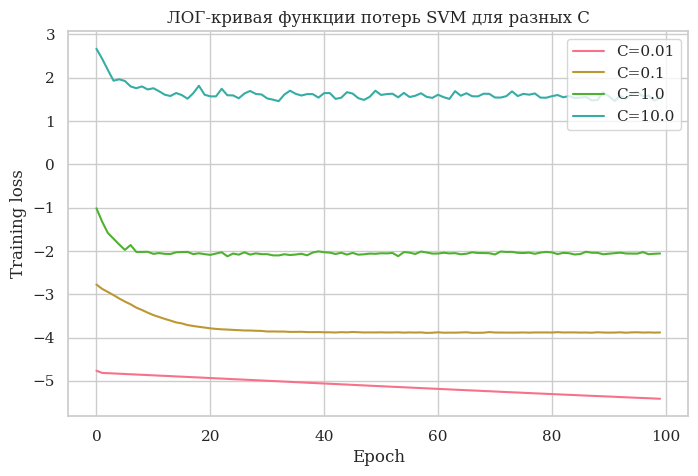

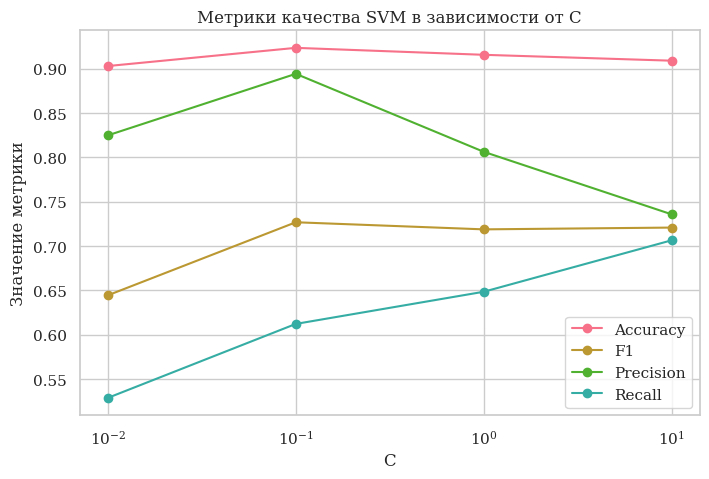

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for C, loss_curve in results_loss.items():
    plt.plot(np.log(loss_curve), label=f"C={C}")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("ЛОГ-кривая функции потерь SVM для разных C")
plt.legend()
plt.grid(True)
plt.show()


Cs = list(results_metrics.keys())
accs  = [results_metrics[C]["accuracy"]  for C in Cs]
f1s   = [results_metrics[C]["f1"]        for C in Cs]
precs = [results_metrics[C]["precision"] for C in Cs]
recs  = [results_metrics[C]["recall"]    for C in Cs]

plt.figure(figsize=(8, 5))
plt.plot(Cs, accs,  marker="o", label="Accuracy")
plt.plot(Cs, f1s,   marker="o", label="F1")
plt.plot(Cs, precs, marker="o", label="Precision")
plt.plot(Cs, recs,  marker="o", label="Recall")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Значение метрики")
plt.title("Метрики качества SVM в зависимости от C")
plt.legend()
plt.grid(True)
plt.show()
